In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from sklearn.linear_model import LogisticRegression

import numpy as np

# Process Model output

In [2]:

["index"] + [f"match{2**i}" for i in range(0, 9)]
all_dfs = []
for i in range(10000, 19001, 1000):
    df = pl.scan_csv(f"results/memorization-dyn-count/evals-running/memorization_1b-v0_{i}_10240000/*.csv", has_header=False, 
            new_columns = ["index", "longest_match", "overlap"])
    # df["index"] = df["index"].cast(pl.Int64)
    df = df.with_columns(checkpoint = pl.lit(i))
    all_dfs.append(df)
all_dfs = pl.concat(all_dfs)

Text(0, 0.5, 'counts')

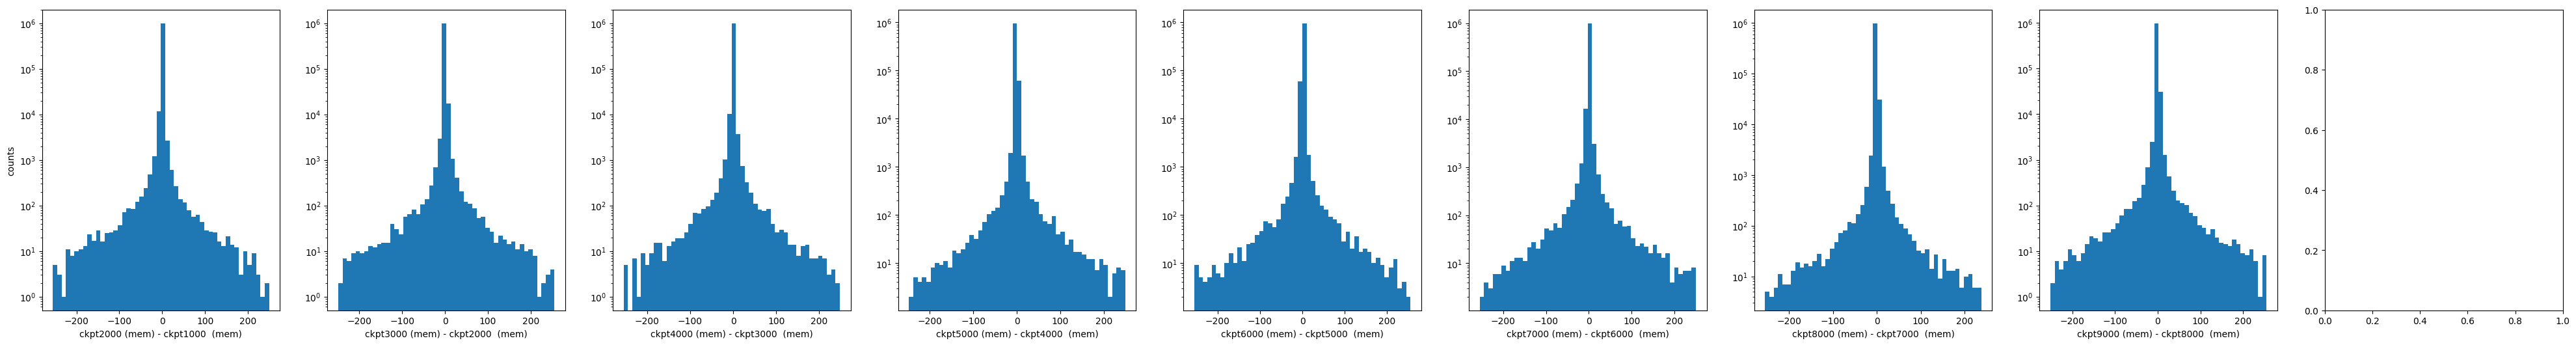

In [3]:
d = all_dfs.collect().pivot("longest_match", "index", "checkpoint", aggregate_function="mean")

f, ax = plt.subplots(1, 9, figsize=(50, 6))
for i in np.arange(1, 9):
    ax[i-1].hist(d[str(i*1000+11000)] - d[str(i*1000 + 10000)], bins=50)
    ax[i-1].set(yscale='log')
    ax[i-1].set_xlabel(f'ckpt{i*1000 + 1000} (mem) - ckpt{i*1000}  (mem)')
ax[0].set_ylabel('counts')


<Axes: >

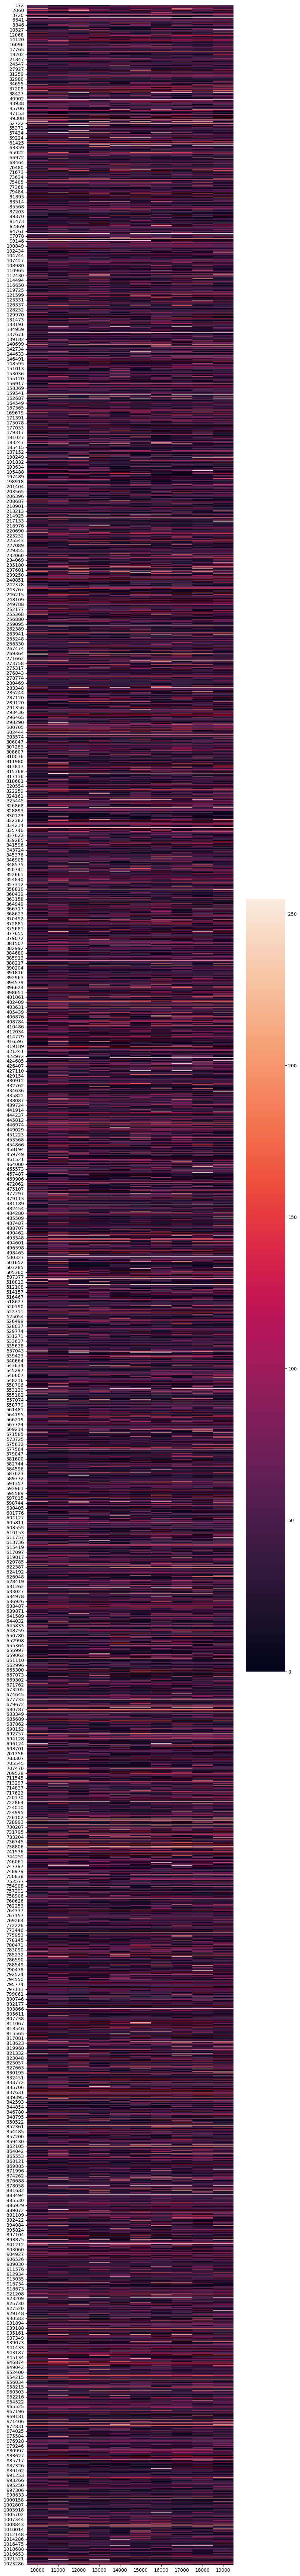

In [4]:
f, ax = plt.subplots(figsize=(10, 100))

df_t = d.to_pandas()
df_t = df_t[(df_t.iloc[:, 1:].max(axis=1)) > 32]
sns.heatmap(df_t.iloc[:, 1:], ax=ax)


# Repeats

In [9]:
df = all_dfs.collect().to_pandas().set_index(["index", "checkpoint"]).sort_values(by=["index", "checkpoint"])
df = df[~df.index.duplicated(keep='first')]
df["diff"] = df["longest_match"].shift(-1) - df["longest_match"]
df

longest_match  overlap  diff
index    checkpoint                              
10240000 10000                   0       10   0.0
         11000                   0        9   0.0
         12000                   0       12   0.0
         13000                   0        9   0.0
         14000                   0        6   0.0
...                            ...      ...   ...
11263999 15000                   1        7   0.0
         16000                   1        3   0.0
         17000                   1        6   0.0
         18000                   1        2   0.0
         19000                   1        4   NaN

[10240000 rows x 3 columns]

Text(0.5, 1.0, 'Complexity (unique tokens)/total')

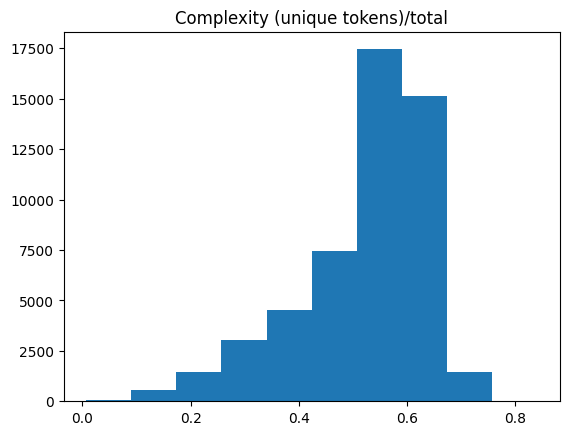

In [10]:
complexity = np.load('zcomplexity.npy')
ser = pd.DataFrame(complexity)
ser.index = np.arange(len(complexity)) * 20 + 1024 * 10000
ser.columns = [30] #np.arange(1, 256)
# ser[0] = 1.0
plt.hist(ser.loc[:, 30])
plt.title("Complexity (unique tokens)/total")

In [11]:
topk = np.load("topk.npy")
repeat_counts = []
for i in range(10):
    repeat_counts.append(np.load(f"repeat_count_{i}.npy"))
counts = np.stack(repeat_counts, axis=1)

index, checkpoint, size = np.unravel_index(np.arange(len(counts.reshape(-1))), counts.shape)
cts = pd.DataFrame(
    {"counts": counts.reshape(-1), "index": index * 20 + 10000 * 1024, "checkpoint": checkpoint*1000 + 10000, "size": size*10})
df = df.join(
    pd.pivot(cts, columns="size", values="counts", index=["index", "checkpoint"]), how='inner')
comp = df.apply(lambda x: ser.loc[x.name[0], 30], axis=1)
df["complexity"] = comp
df["cumsum30"] = df.groupby("index")[30].transform(pd.Series.cumsum)

In [12]:
df.to_parquet('analysis.parquet.gzip',
              compression='gzip') 

/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [22]:
memorized_indices = df[df["longest_match"] > 10].index.get_level_values(0).unique().to_numpy()
np.save('memorized_indices', memorized_indices)

In [24]:
memorized_indices.shape

(1490,)

# Visualize

In [10]:
df = pd.read_parquet('analysis.parquet.gzip')  

Text(0.5, 1.0, 'match-repeat (complexity > 0.8)')

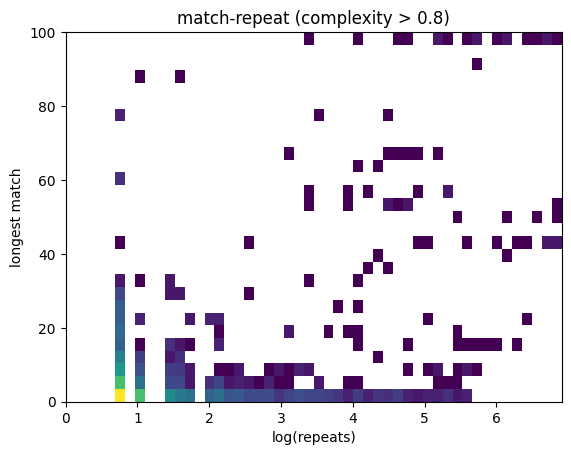

In [14]:
df_t = df.loc[df["complexity"] >0.6]
plt.hist2d(np.log(df_t["cumsum30"].astype(float)+1), np.clip(df_t["longest_match"], 0, 100), 
#            xscale='log',
#            bins=(50, 50),
#            range=[[0, 100], [0, 50]],
           bins=[np.linspace(0, np.log(1000), 51), np.linspace(0, 100, 30)], 
           norm='log',
#             alpha=0.1
          );
plt.xlabel("log(repeats)")
plt.ylabel("longest match")
plt.title("match-repeat (complexity > 0.8)")

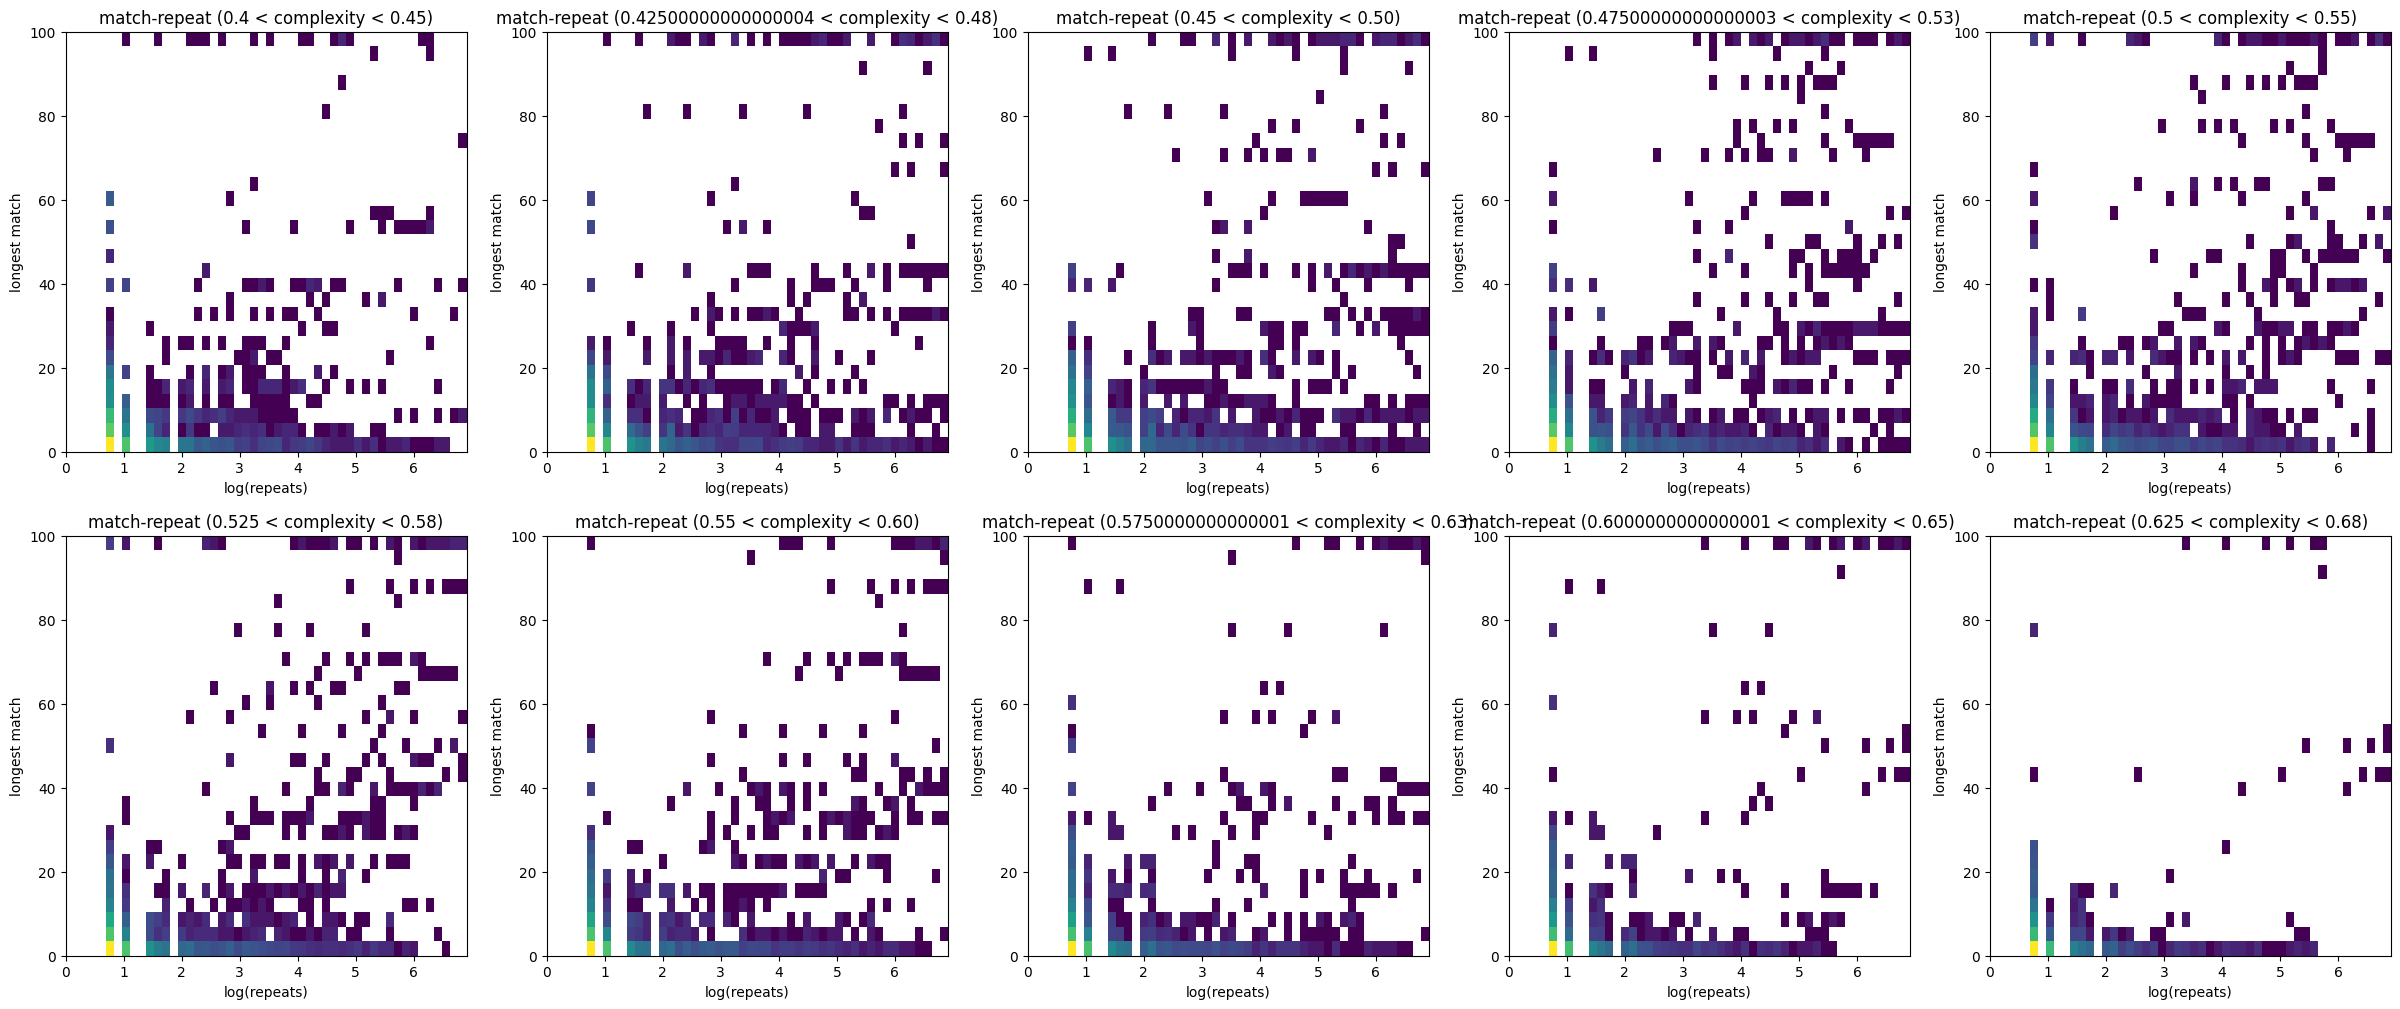

In [19]:
f, ax = plt.subplots(2, 5, figsize=(30, 12))
for i in range(10):
    comp = 0.025 * i + 0.4
    df_t = df.loc[(df["complexity"] > comp) & (df["complexity"] <= comp+0.05)]
    ax[i // 5, i % 5].hist2d(np.log(df_t["cumsum30"].astype(float)+1), np.clip(df_t["longest_match"], 0, 100), 
    #            xscale='log',
    #            bins=(50, 50),
    #            range=[[0, 100], [0, 50]],
               bins=[np.linspace(0, np.log(1000), 51), np.linspace(0, 100, 30)], 
               norm='log',
    #             alpha=0.1
              );
    ax[i // 5, i % 5].set(xlabel="log(repeats)", ylabel="longest match", title=f"match-repeat ({comp} < complexity < {comp+0.05:0.2f})")

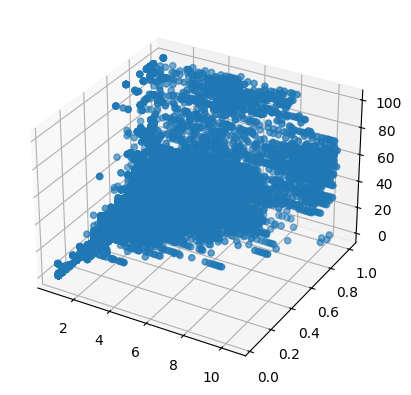

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.log(df["cumsum30"].astype(float)+1), df["complexity"], np.clip(df["longest_match"], 0, 100))

In [13]:
df.index.get_level_values(1)

Index([10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000,
       ...
       10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000],
      dtype='int32', name='checkpoint', length=512000)

In [14]:
df_t["10"]

index     checkpoint
10240180  10000         1
          11000         0
          12000         0
          13000         0
          14000         0
                       ..
11263520  15000         0
          16000         0
          17000         0
          18000         0
          19000         1
Name: 10, Length: 34990, dtype: int64

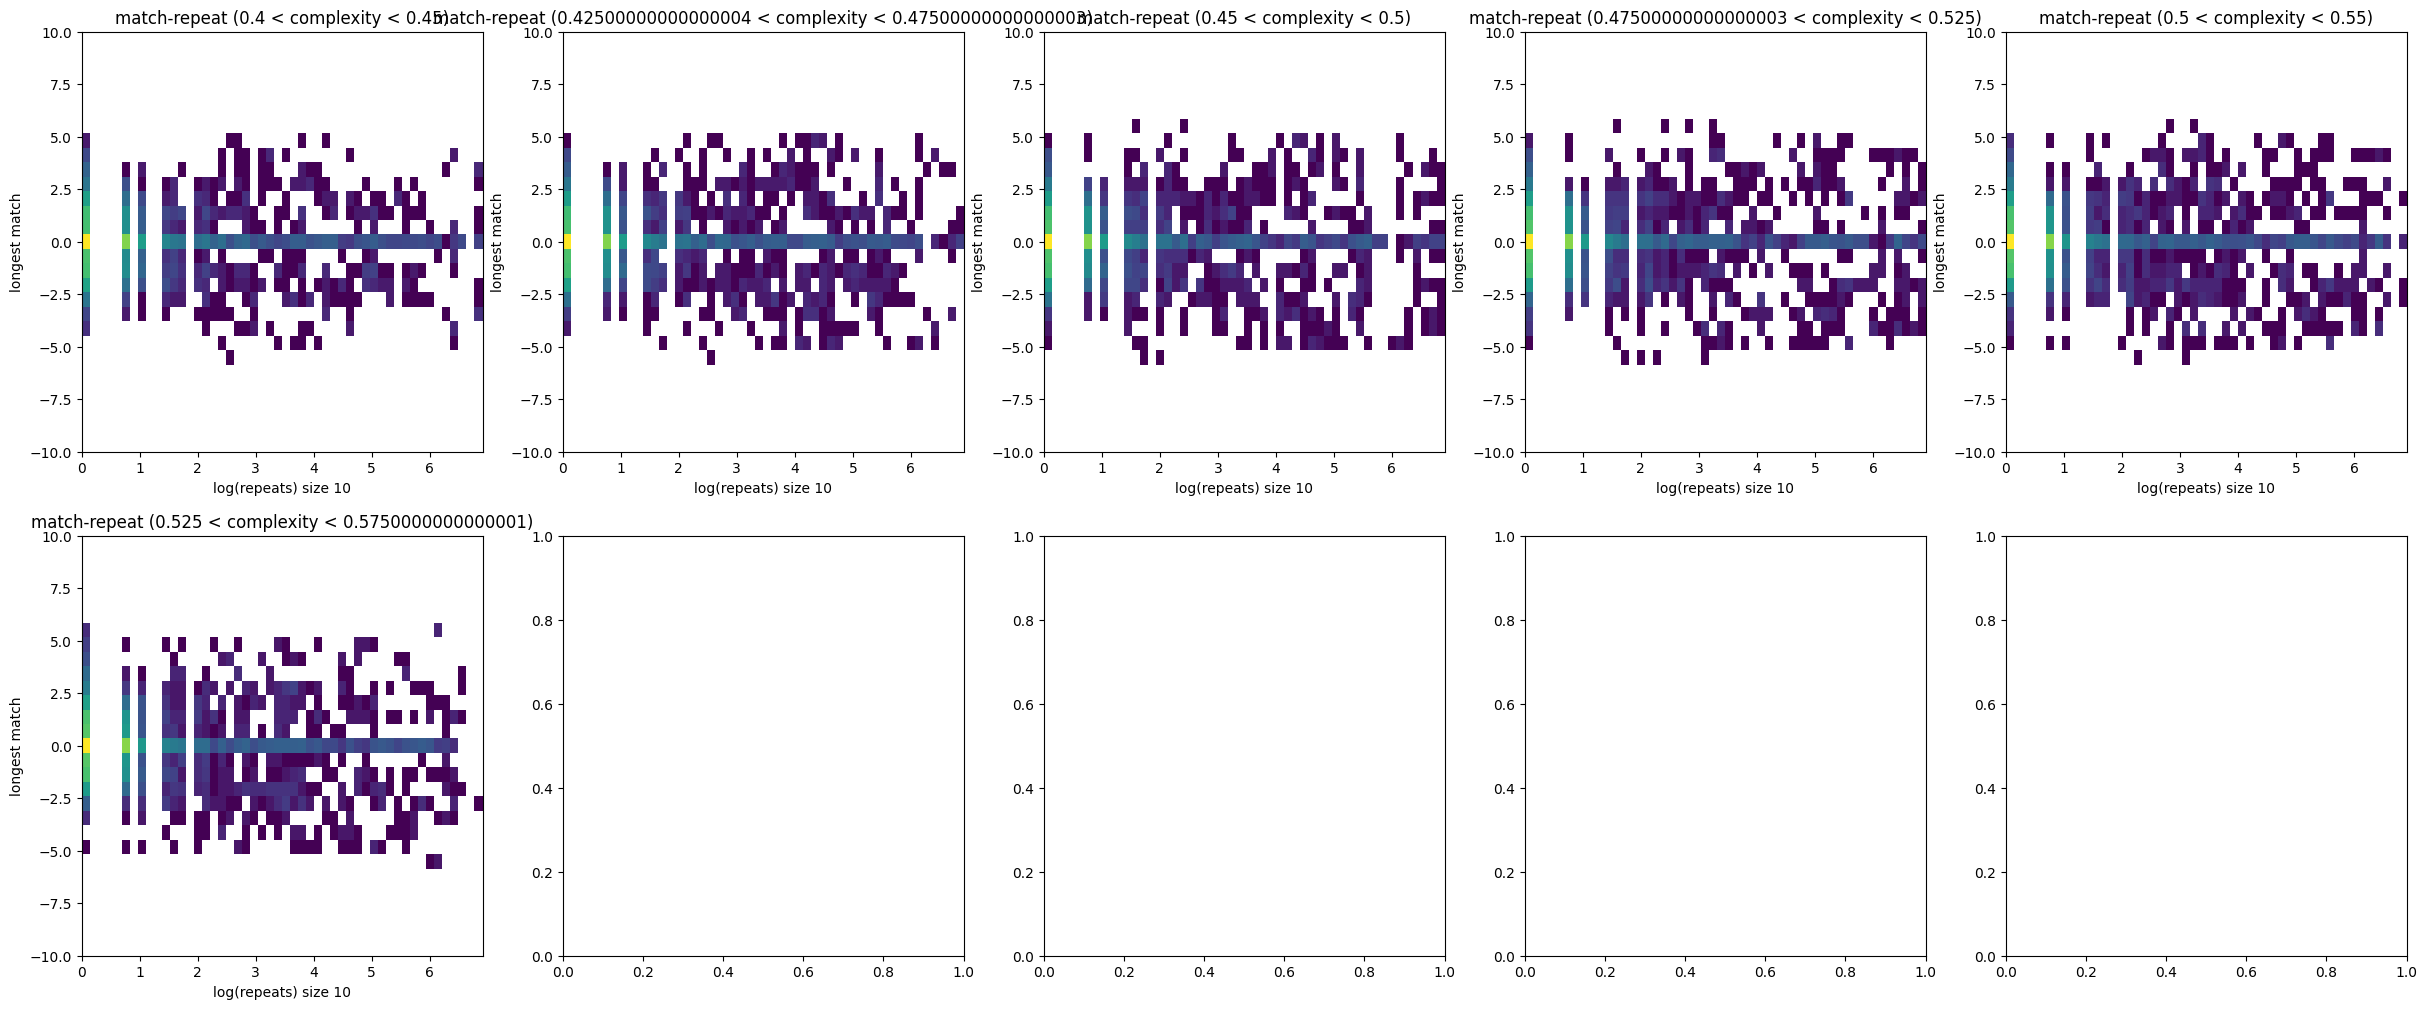

In [22]:
f, ax = plt.subplots(2, 5, figsize=(30, 12))
for i in range(6):
    comp = 0.025 * i + 0.4
    df_t = df.loc[(df["complexity"] > comp) & (df["complexity"] <= comp+0.05) & (df.index.get_level_values(1) > 3000)]
    ax[i // 5, i % 5].hist2d(
        np.log(df_t["10"].astype(float)+1), 
        np.log(np.abs(df_t["diff"])+1) * np.sign(df_t["diff"]), 
    #            xscale='log',
    #            bins=(50, 50),
    #            range=[[0, 100], [0, 50]],
               bins=[np.linspace(0, np.log(1000), 51), np.linspace(-10, 10, 30)], 
               norm='log',
    #             alpha=0.1
              );
    ax[i // 5, i % 5].set(xlabel="log(repeats) size 10", ylabel="longest match", title=f"match-repeat ({comp} < complexity < {comp+0.05})")

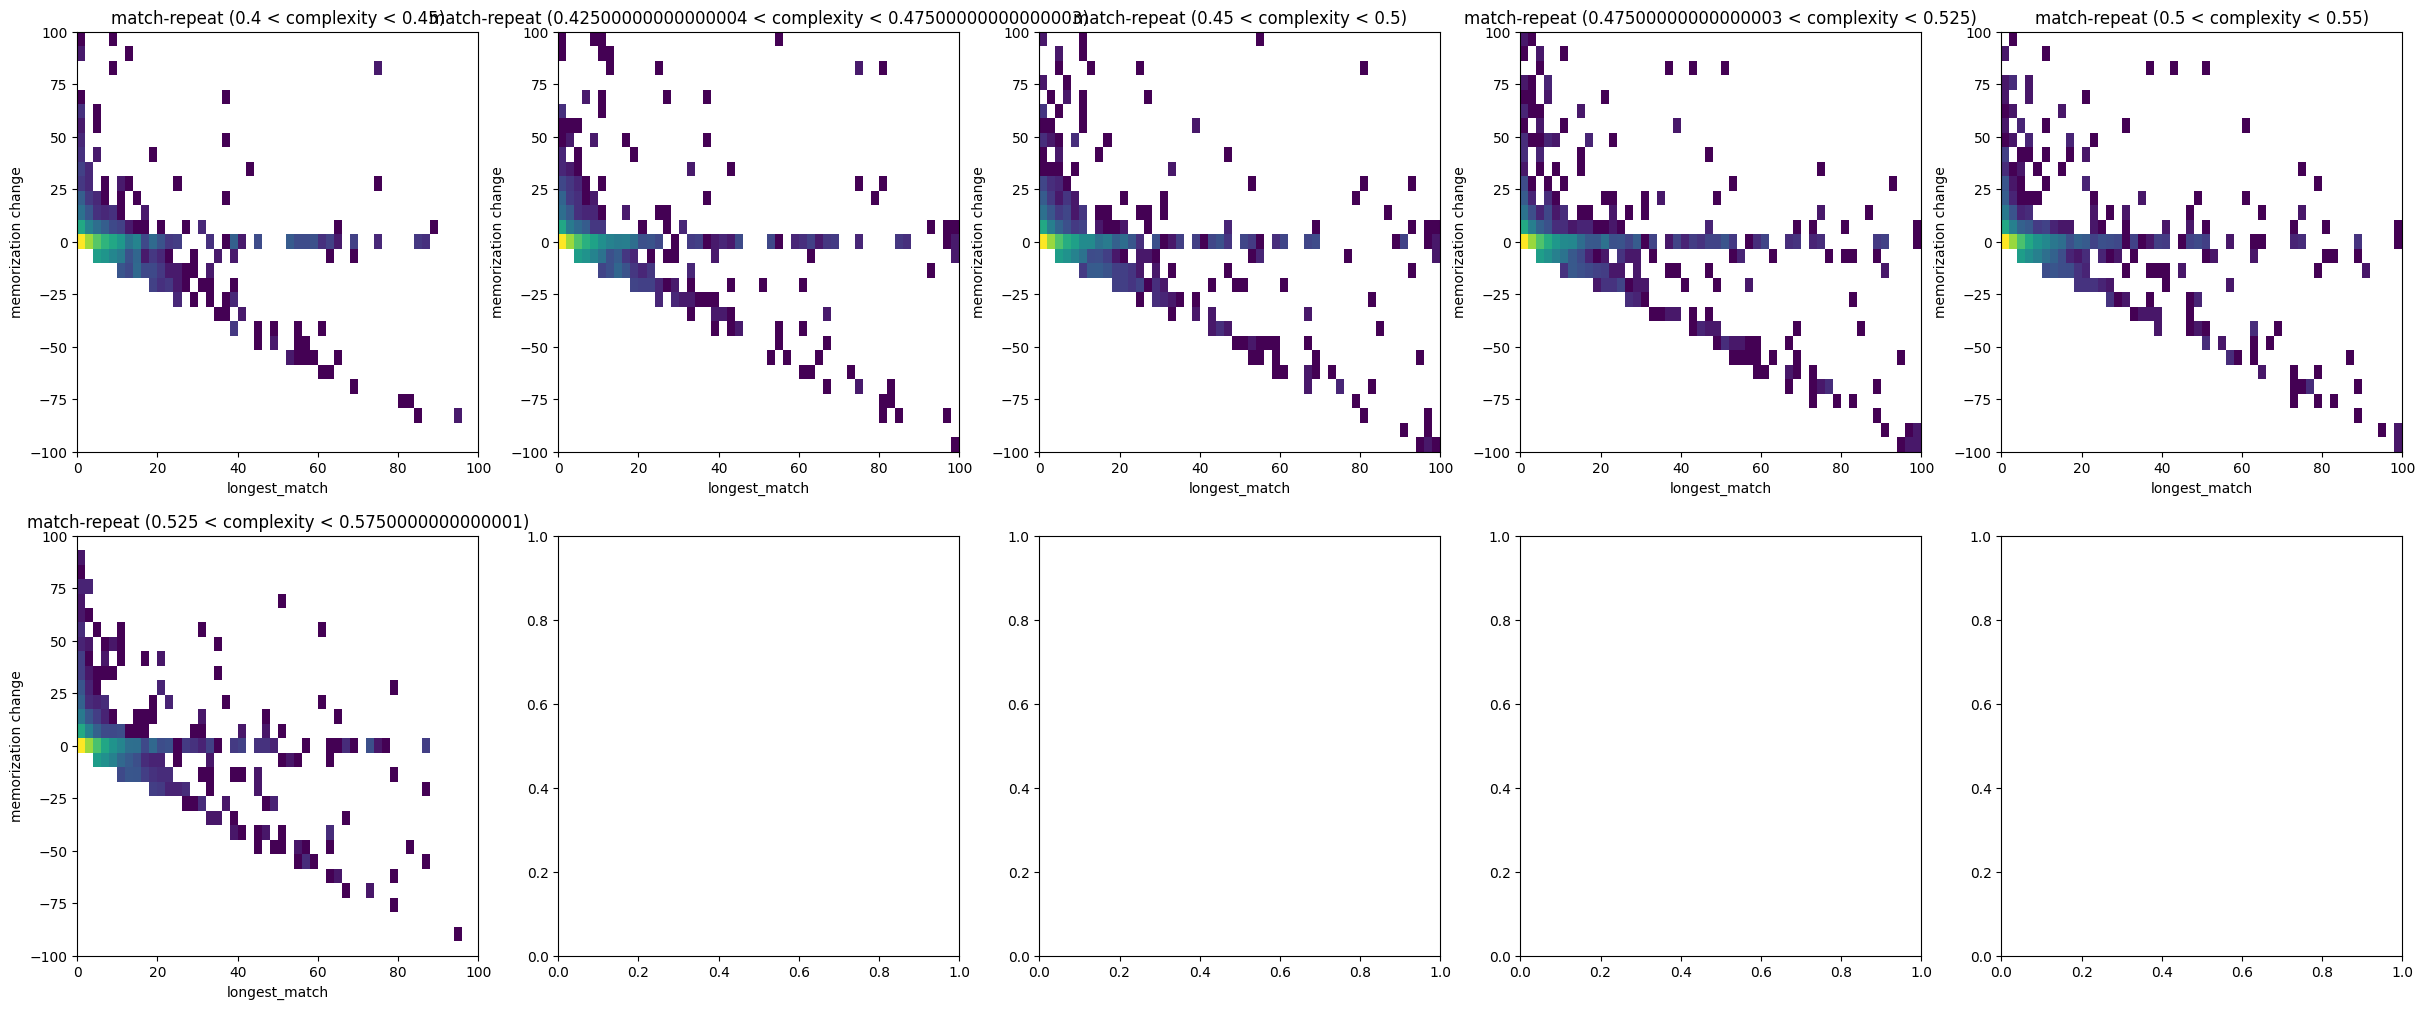

In [24]:
f, ax = plt.subplots(2, 5, figsize=(30, 12))
for i in range(6):
    comp = 0.025 * i + 0.4
    df_t = df.loc[(df["complexity"] > comp) & (df["complexity"] <= comp+0.05)]
    ax[i // 5, i % 5].hist2d(
        df_t["longest_match"],
        df_t["diff"], 
    #            xscale='log',
    #            bins=(50, 50),
    #            range=[[0, 100], [0, 50]],
               bins=[np.linspace(0, 100, 51), np.linspace(-100, 100, 30)], 
               norm='log',
    #             alpha=0.1
              );
    ax[i // 5, i % 5].set(xlabel="longest_match", ylabel="memorization change", title=f"match-repeat ({comp} < complexity < {comp+0.05})")

<Axes: xlabel='checkpoint', ylabel='index'>

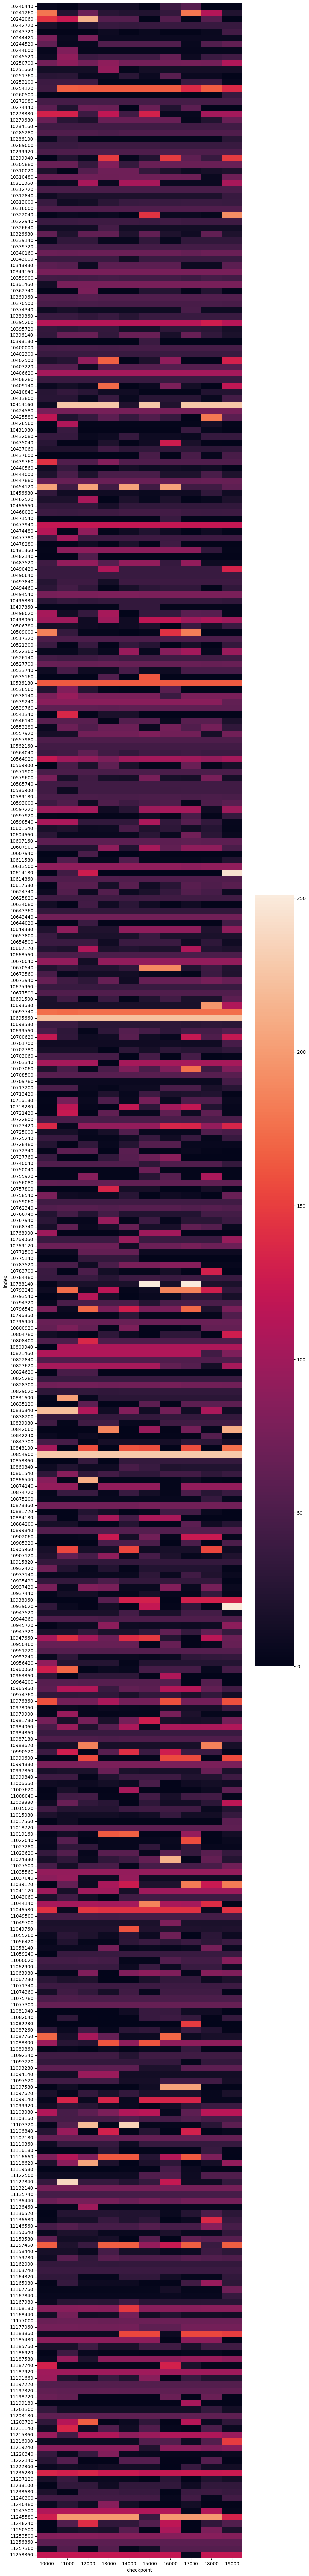

In [17]:
f, ax = plt.subplots(figsize=(10, 100))

df_t = df["longest_match"].unstack(1).loc[(df["longest_match"].unstack(1) > 32).max(axis=1)]
df_t
sns.heatmap(df_t, ax=ax)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(6)
dim = pca.fit_transform(df_t.dropna().to_numpy())

[Text(50.722222222222214, 0.5, 'component number'),
 Text(0.5, 23.52222222222222, 'time')]

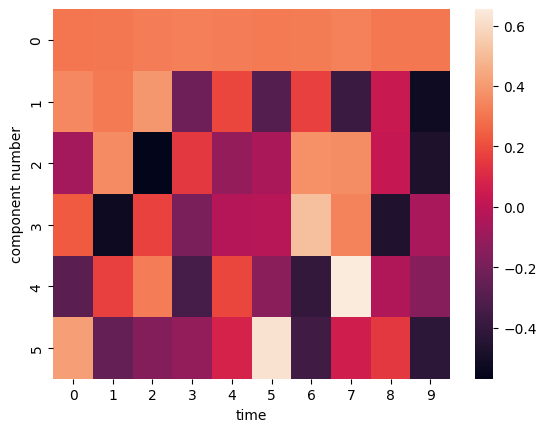

In [54]:
f, ax = plt.subplots()
sns.heatmap(pca.components_)
ax.set(ylabel='component number', xlabel='time')

In [49]:
pca.explained_variance_ratio_

array([0.51388434, 0.0854767 , 0.07431903, 0.06175354, 0.05355314,
       0.04773573])

[Text(0.5, 1.0, 'First 2 pcs')]

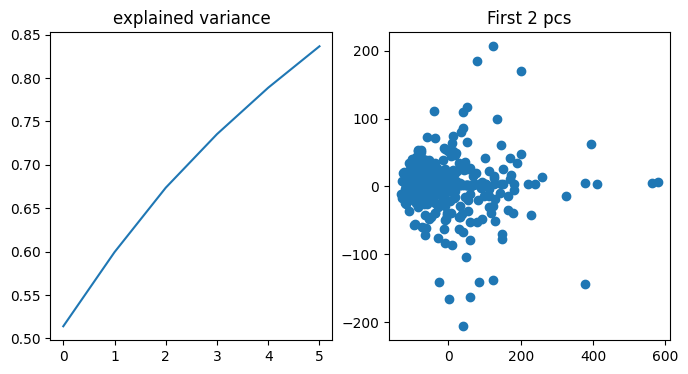

In [55]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(np.cumsum(pca.explained_variance_ratio_))
ax[0].set(title='explained variance')
ax[1].scatter(dim[:, 0], dim[:, 1])
ax[1].set(title='First 2 pcs')

In [166]:
(df["longest_match"].unstack(1) > 32).sum(axis=1) 

index
0          0
20         0
40         0
60         0
80         0
          ..
1023900    0
1023920    0
1023940    0
1023960    0
1023980    0
Length: 51200, dtype: int64

In [131]:
# Analyze hard matches

In [31]:
hard_matches = df1[(df1["complexity"]>0.6) & (df1["longest_match"] > 32)] #& (df1[10] < 10)]
hard_matches.index.get_level_values(0).unique()

Index([   1060,   10060,   30540,   31140,   37480,   44280,   45880,   77580,
         87780,  100540,
       ...
        962620,  964600,  966680,  969880,  980780,  989660,  998360,  998760,
       1000780, 1018840],
      dtype='int64', name='index', length=182)

In [ ]:
plt.hist2d(df1["cumsum30"], df1["longest_match"], 
           bins=(np.linspace(0, 100, 20), np.linspace(0, 250, 30)),
          norm='log');
# plt.ylim(0, 30)
# plt.xlim(0, 50)

In [51]:
df2 = pd.melt(df1.reset_index(), id_vars=["index", "checkpoint", "longest_match"], value_vars = np.arange(0, 26) * 10)
df2

,index,checkpoint,longest_match,variable,value
0,0,1000,0,0,1020
1,0,2000,0,0,907
2,0,3000,0,0,934
3,0,4000,0,0,980
4,0,5000,0,0,926
...,...,...,...,...,...
11980795,1023980,5000,2,250,0
11980796,1023980,6000,2,250,0
11980797,1023980,7000,2,250,0
11980798,1023980,8000,2,250,0


In [55]:
# g = sns.FacetGrid(df1[df1["variable"] % 40 == 0], col="checkpoint", row="value")
# sns.relplot(df1, x="value", y="diff")

In [56]:
# f, ax = plt.subplots(13, 10, figsize=(120, 300))
# for x, i in enumerate(np.arange(1000, 10001, 1000)):
#     for y, j in enumerate(np.arange(10, 261, 20)):
#         df_t = df1[(df1["variable"] == j) & (df1["checkpoint"] == i)]
# #         ax[y, x].scatter(df_t["value"], df_t["diff"])
#         ax[y, x].hist2d(df_t["value"], df_t["diff"], bins=50, norm='log')
#         print(i, j)

(array([[3.70055e+05, 3.88810e+04, 1.82770e+04, ..., 1.60000e+01,
         0.00000e+00, 7.00000e+00],
        [6.30000e+02, 1.21000e+02, 7.50000e+01, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [3.26000e+02, 5.60000e+01, 3.00000e+01, ..., 0.00000e+00,
         0.00000e+00, 1.00000e+00],
        ...,
        [5.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [2.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [6.00000e+00, 2.00000e+00, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00]]),
 array([ 0.        ,  1.02040816,  2.04081633,  3.06122449,  4.08163265,
         5.10204082,  6.12244898,  7.14285714,  8.16326531,  9.18367347,
        10.20408163, 11.2244898 , 12.24489796, 13.26530612, 14.28571429,
        15.30612245, 16.32653061, 17.34693878, 18.36734694, 19.3877551 ,
        20.40816327, 21.42857143, 22.44897959, 23.46938776, 24.48979592,
        

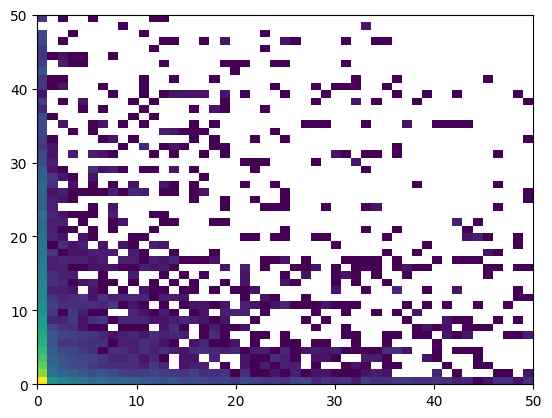

In [53]:
df_t = df2[(df2["variable"] == 30)]
plt.hist2d(df_t["value"], df_t["longest_match"], bins=[np.linspace(0, 50, 50), np.linspace(0, 50, 50)], norm='log')

# Individual runs

In [110]:
idx = 1060
# idx = 20

(0.0, 256.0)

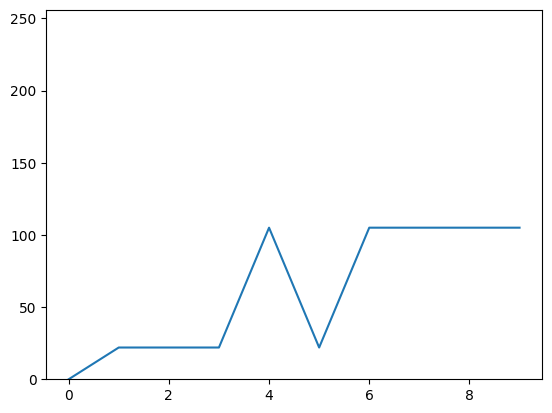

In [112]:
plt.plot(dyn.to_numpy()[0, 1:].T)
plt.ylim(0, 256)

In [113]:

df1[(df1["index"] == idx)]["longest_match"]

477           0
478          22
479          22
480          22
481         105
           ... 
11520481    105
11520482     22
11520483    105
11520484    105
11520485    105
Name: longest_match, Length: 234, dtype: int64

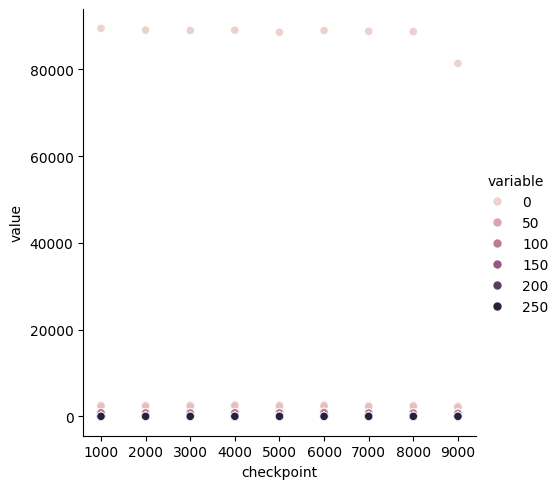

In [114]:
sns.relplot(df1[df1["index"] == idx], x='checkpoint', y='value', hue='variable')

# Regression Analysis

In [62]:
df_f = df.filter(pl.col("index") < 100000).collect()
df_f = df_f.to_pandas().set_index("index")

df_f["longest_match"] = 0
for i in range(9):
    df_f.loc[df_f[f"match{2**i}"] == 1.0, "longest_match"] = 2**i

df_f = df_f.groupby("index").agg(["mean", "std"])
df_f.columns = ['_'.join(col).strip() for col in df_f.columns.values]
df_f

,match1_mean,match1_std,match2_mean,match2_std,match4_mean,match4_std,match8_mean,match8_std,match16_mean,match16_std,...,match64_mean,match64_std,match128_mean,match128_std,match256_mean,match256_std,checkpoint_mean,checkpoint_std,longest_match_mean,longest_match_std
index,,,,,,,,,,,,,,,,,,,,,
0,0.1,0.316228,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.1,0.316228
1,0.6,0.516398,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.6,0.516398
2,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000
3,0.2,0.421637,0.2,0.421637,0.2,0.421637,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.8,1.686548
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.3,0.483046,0.3,0.483046,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.6,0.966092
99996,1.0,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,2.0,0.000000
99997,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000


In [64]:
topk = np.load("topk.npy")
repeat_count = np.load("repeat_count.npy")

In [65]:
checkpoint, index, size = np.unravel_index(np.arange(len(repeat_count.reshape(-1))), repeat_count.shape)
df_r = pd.DataFrame()
df_r["count"] = repeat_count.reshape(-1)
df_r["repeat_size"] = [f"repeat_{2**s}" for s in size] 
df_r["index"] = index
df_r["checkpoint"] = checkpoint * 1000 + 1000
df_r = df_r.pivot(index=["checkpoint", "index"], values="count", columns="repeat_size")
# df_r = df_f.set_index("index")
df_r = df_r.reset_index(level=[0])
df_r = df_r.groupby("index").agg("sum")
# df_r.columns = ['_'.join(col).strip() for col in df_r.columns.values]
df_r

repeat_size,checkpoint,repeat_1,repeat_16,repeat_2,repeat_32,repeat_4,repeat_64,repeat_8
index,,,,,,,,
0,45000,349282,3,2898,2,151,1,3
1,45000,434566,1,4196,1,69,1,1
2,45000,410217,3,3363,1,145,1,13
3,45000,373144,1,1178,1,628,1,4
4,45000,558504,102,45326,2,572,1,111
...,...,...,...,...,...,...,...,...
99995,45000,538840,1,1803,1,20,1,1
99996,45000,886715,12,22404,12,27,12,12
99997,45000,538090,1,25856,1,15,1,6


In [66]:
data = topk[:, :, 1].T
index, checkpoint = np.unravel_index(np.arange(len(data.reshape(-1))), data.shape)
df_x = pd.DataFrame()
df_x["topmatch"] = data.reshape(-1)
df_x["checkpoint"] = checkpoint * 1000 + 1000
df_x["index"] = index
df_x = df_x.set_index("index")
df_x

,topmatch,checkpoint
index,,
0,6,1000
0,13,2000
0,13,3000
0,15,4000
0,6,5000
...,...,...
99999,5,5000
99999,4,6000
99999,4,7000


In [67]:
# df_c = df_x.join(df_f, on=["index", "checkpoint"], how='inner')
# df_c = pd.merge(df_x, df_f,  how='inner', left_on=["index", "checkpoint"], right_on = ["index", "checkpoint"])
# df_c = pd.merge(df_c, df_r,  how='inner', left_on=["index", "checkpoint"], right_on = ["index", "checkpoint"])
df_c = pd.merge(df_r, df_f,  how='inner', left_on=["index"], right_on = ["index"])
df_c

,checkpoint,repeat_1,repeat_16,repeat_2,repeat_32,repeat_4,repeat_64,repeat_8,match1_mean,match1_std,...,match64_mean,match64_std,match128_mean,match128_std,match256_mean,match256_std,checkpoint_mean,checkpoint_std,longest_match_mean,longest_match_std
index,,,,,,,,,,,,,,,,,,,,,
0,45000,349282,3,2898,2,151,1,3,0.1,0.316228,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.1,0.316228
1,45000,434566,1,4196,1,69,1,1,0.6,0.516398,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.6,0.516398
2,45000,410217,3,3363,1,145,1,13,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000
3,45000,373144,1,1178,1,628,1,4,0.2,0.421637,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.8,1.686548
4,45000,558504,102,45326,2,572,1,111,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,45000,538840,1,1803,1,20,1,1,0.3,0.483046,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.6,0.966092
99996,45000,886715,12,22404,12,27,12,12,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,2.0,0.000000
99997,45000,538090,1,25856,1,15,1,6,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,5500.0,3027.650354,0.0,0.000000


<Axes: xlabel='repeat_8', ylabel='longest_match_std'>

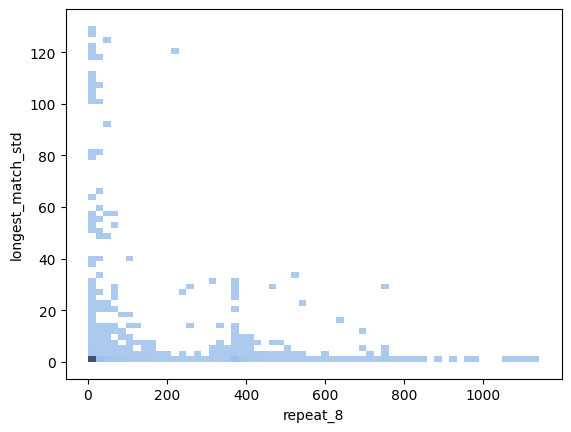

In [94]:
sns.histplot(df_c, x="repeat_8", y="longest_match_std", bins=60)

<Axes: xlabel='repeat_64', ylabel='longest_match_mean'>

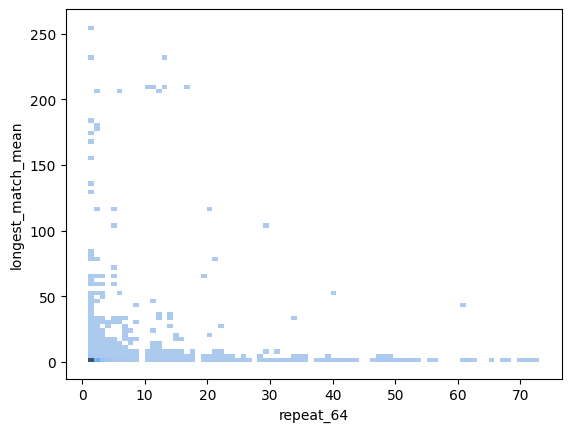

In [93]:
sns.histplot(df_c, x="repeat_64", y="longest_match_mean", bins=80)

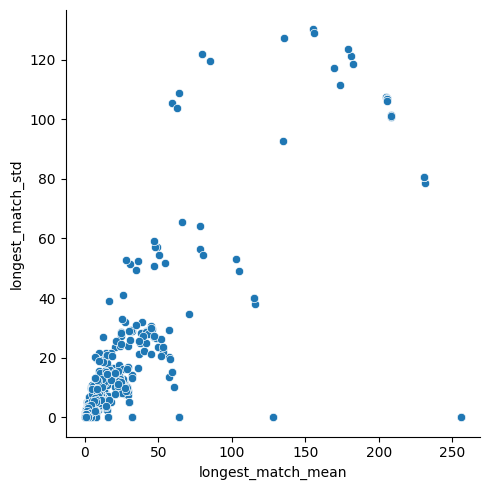

In [90]:
sns.relplot(df_c, x="longest_match_mean", y="longest_match_std")

/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


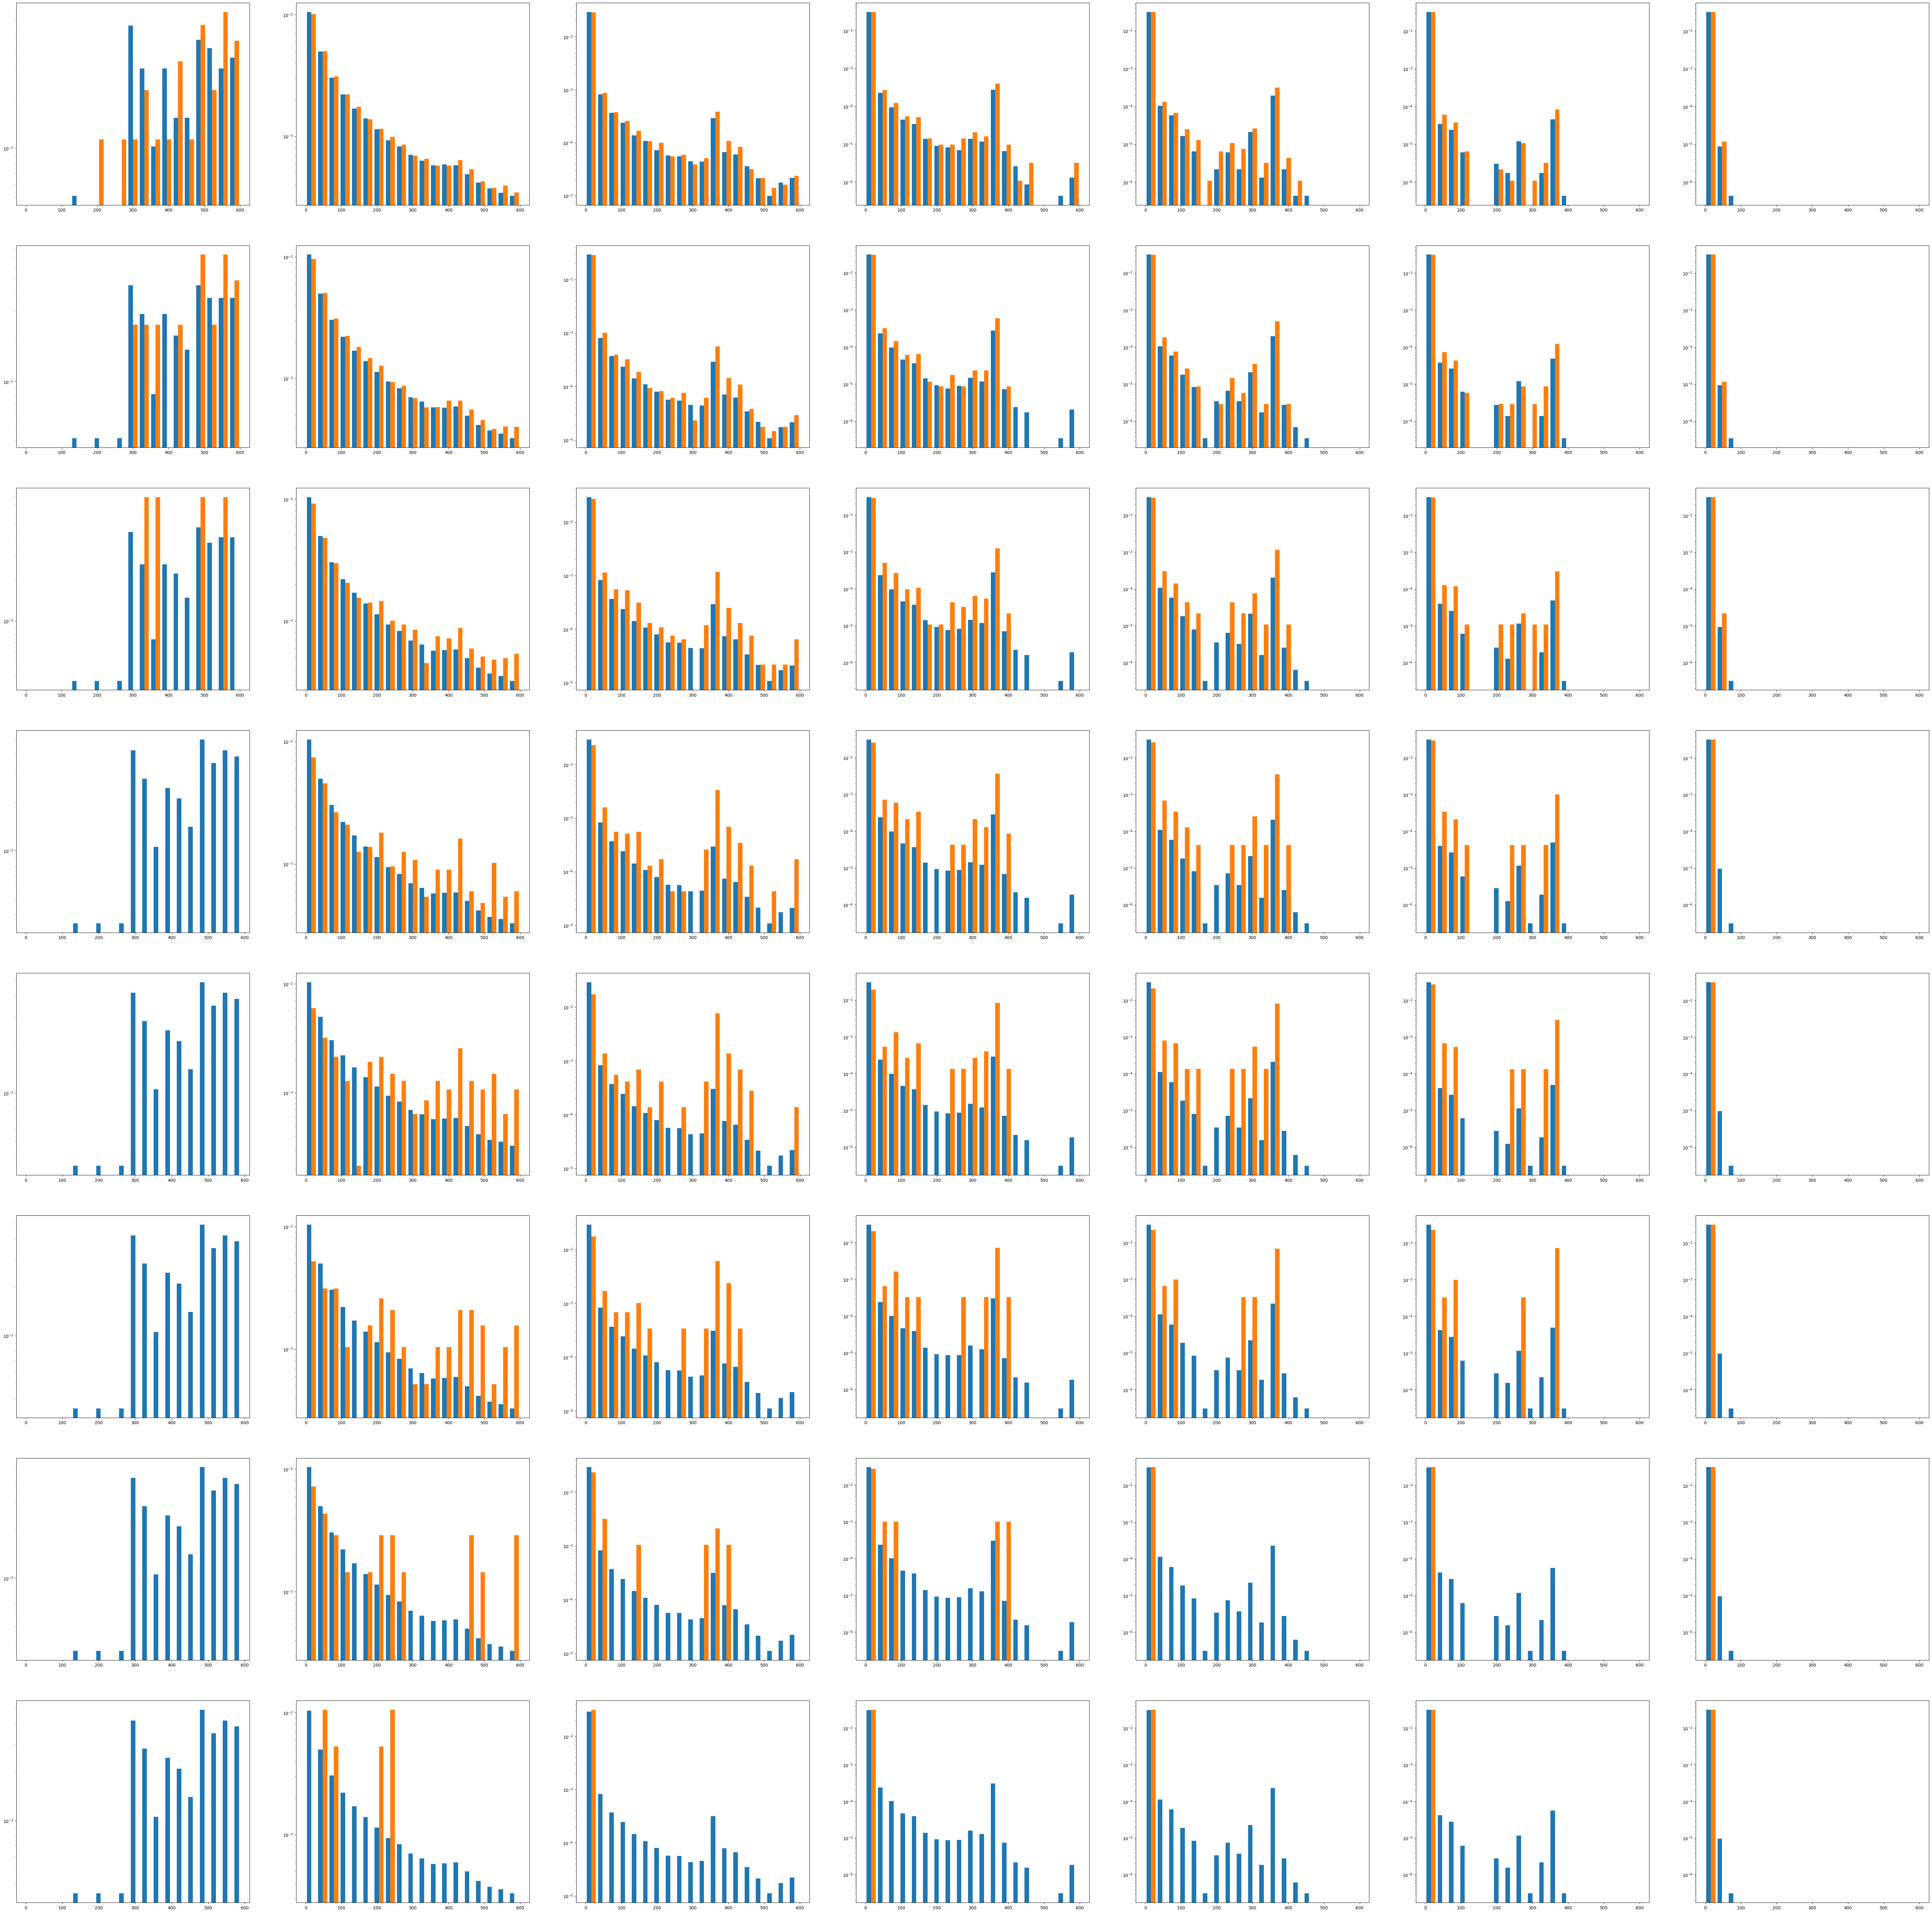

In [109]:
# sns.relplot(df_c, x='repeat_8', y='match8')
f, ax = plt.subplots(8, 7, figsize=(80, 80))
for i in range(8): # match_num
    for j in range(7): # repeat
        match_num = 2**i
        repeat_num = 2**j
        ax[i, j].hist([df_c[df_c[f"match{match_num}"] == 0][f"repeat_{repeat_num}"], 
                       df_c[df_c[f"match{match_num}"] == 1][f"repeat_{repeat_num}"]], 
                      bins=np.linspace(0, 600, 20), density=True);
        ax[i, j].set(yscale='log')

In [ ]:
# sns.relplot(df_c, x='repeat_8', y='match8')
f, ax = plt.subplots(8, 7, figsize=(80, 80))
for i in range(8): # match_num
    for j in range(7): # repeat
        match_num = 2**i
        repeat_num = 2**j
        ax[i, j].hist([df_c[df_c[f"match{match_num}"] == 0][f"repeat_{repeat_num}"], 
                       df_c[df_c[f"match{match_num}"] == 1][f"repeat_{repeat_num}"]], 
                      bins=np.linspace(0, 600, 20), density=True);
        ax[i, j].set(yscale='log')

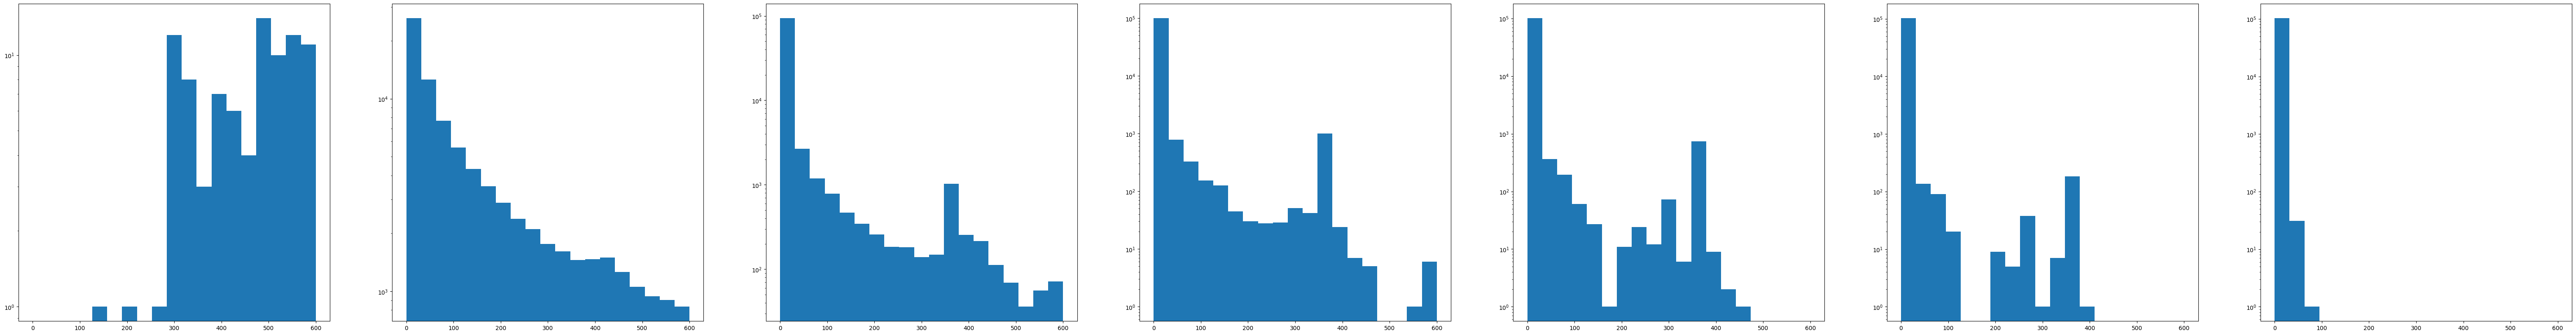

In [117]:
f, ax = plt.subplots(1, 7, figsize=(80, 10))
for j in range(7):
    repeat_num = 2**j
    ax[j].hist(df_c[f"repeat_{repeat_num}"],
                      bins=np.linspace(0, 600, 20));
    ax[j].set(yscale='log')

In [ ]:
sns.displot(df_c, x="")

In [92]:
X =df_c[["topmatch", "checkpoint"]].to_numpy()
y = df_c[[f"match{int(2**i)}" for i in range(0, 9)]]
y = df_c["match256"]

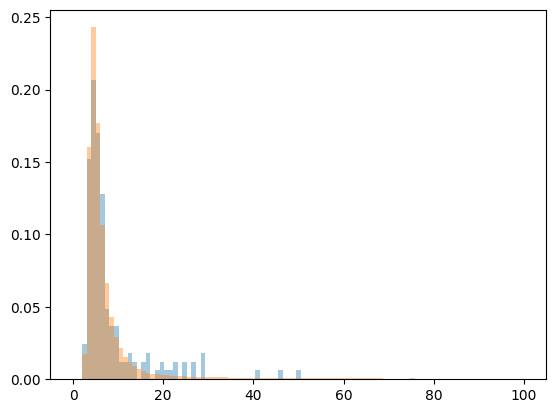

In [93]:
# plt.hist(X[y==1, 0])

plt.hist(X[y==1, 0], bins=np.linspace(0, 100, 100), density=True, alpha=0.4);
plt.hist(X[y==0, 0], bins=np.linspace(0, 100, 100), density=True, alpha=0.4);


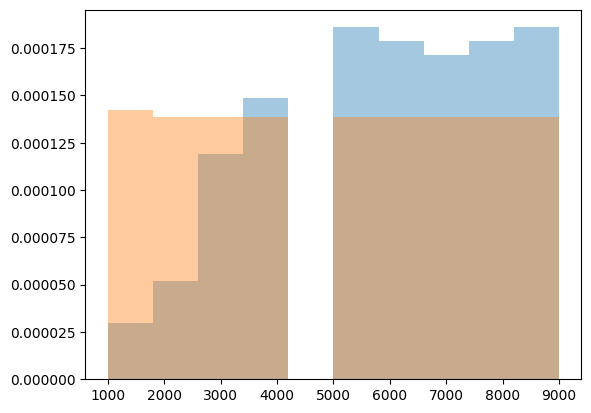

In [94]:

plt.hist(X[y==1, 1], density=True, alpha=0.4);
plt.hist(X[y==0, 1], density=True, alpha=0.4);

In [ ]:
log = LogisticRegression()
log.fit(X, y)

## TODO
- Compare the variance, slope, mean, etc. of the dynamics with number of repeats
- Run the analysis for the last 100k sequences before end of the checkpoint
- Run larger models (1b) 